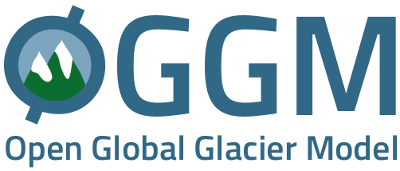

# Ice thickness inversion with frontal ablation: a case study

In this notebook we are illustrating how OGGM searches for a frontal calving flux which is compatible with mass conservation, ice thickness estimation based on Glen's flow law, and the calving parameterization of [Oerlemans and Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F).

For more details, see [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/).

## Set-up

These are the usual OGGM workflow commands.

In [1]:
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core.inversion import find_inversion_calving, calving_flux_from_depth

In [3]:
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Calving', reset=True)
cfg.PARAMS['border'] = 10

2019-06-26 17:17:01: oggm.cfg: Using configuration file: /home/mowglie/Documents/git/oggm-fork/oggm/params.cfg


## Pick a glacier 

Here we experiment with Leconte glacier (`RGI60-01.03622`). But you can try with other glaciers as well! See [this list](https://github.com/OGGM/oggm-edu/tree/master/data/tidewater_glaciers_wo_processing.csv) for nearly all glaciers simulated in [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/) (we took out the glaciers that need special processing, i.e. because of incorrect outlines like Columbia).

In [4]:
gdir = workflow.init_glacier_regions(['RGI60-01.03622'], from_prepro_level=3)[0]

2019-06-26 17:17:07: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-06-26 17:17:07: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2019-06-26 17:17:07: oggm.workflow: Multiprocessing: using all available processors (N=8)


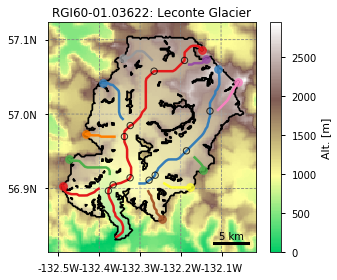

In [5]:
graphics.plot_centerlines(gdir, use_flowlines=True);

**Let's first see the results of the inversion without calving:**

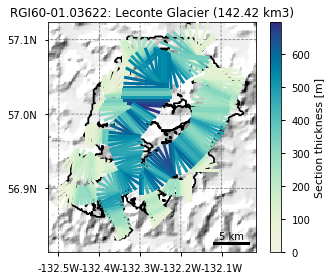

In [6]:
graphics.plot_inversion(gdir);

## The basic principles

We use a simple calving law borrowed from [Oerlemans and Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F), which relates the frontal calving flux $q_{calving}$ to the frontal ice thickness $h_f$, the water depth $d$ and the terminus width $w$

 $$q_{calving} = k h_f d w \; (EQ. \: 1)$$ 

With $q_{calving}$ in km$^3$ yr$^{-1}$, $k$ a calibration parameter (default 2.4 yr$^{-1}$) and $d =$ $h_{f}$ - $E_{t}$ ($E_{t}$ being the free board).

As explained in [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/), ice conservation methods applied to tidewater glaciers *must* take into account this mass-flux at the terminus, otherwise the ice thickness is underestimated. In fact, the default OGGM ice thickness inversion procedure assumes an ice flux of zero at the terminus: 

In [7]:
# Default calving flux:
calving_flux_from_depth(gdir)

{'flux': -0.0,
 'free_board': 84.02454858723632,
 'thick': 0.0,
 'water_depth': -84.02454858723632,
 'width': 775.0304918212076}

Here, `flux` is the calving flux ($q_{calving}$) in km$^3$ yr$^{-1}$, `free_board` is the height of ice above water ($E_{t}$, i.e. above 0 m a.s.l), `thick` the frontal ice thickness ($h_{f}$) in m (equal to zero per construction in OGGM), `water_depth` the water depth in m (negative here because of the zero ice thickness and a terminus elevation equal to the freeboard imply a positive bedrock elevation), `width` the front width in m.

Now let's see how this calving flux would change if we increase the ice thickness (while keeping the free board fixed, because the surface elevation at the terminus is the only thing we know with "certainty"):

In [8]:
df = []
for thick in np.linspace(0, 500, 51):
    # This function simply computes the calving law
    df.append(calving_flux_from_depth(gdir, thick=thick))
df = pd.DataFrame(df).set_index('thick')

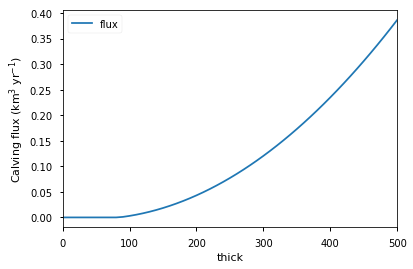

In [9]:
df[['flux']].plot();
plt.ylabel('Calving flux (km$^3$ yr$^{-1}$)');

The flux is zero as long as the ice isn't thick enough to reach the water surface, after which the water depth is positive and calving occurs. The calving flux varies with $H$ as a polynomial of degree 2.

We don't know which is the **real** value of the calving flux at this glacier. From here, let's make some very coarse assumptions:
- the Oerlemans and Nick calving law is perfectly exact
- the tuning parameter $k$ is known
- our glacier is in equilibrium (a fundamental assumption necessary for mass-conservation inversion)
- ice deformation at the glacier terminus follows Glen's flow law

Under these assumptions, we are now going to show that there is **one and only one** value for the frontal thickness (water depth, $h_{f}$ = $d$ + $E_{t}$) which complies with; the calving law, the ice thickness inversion model of OGGM and **mass conservation**.

To test this hypothesis, we are going to compute a calving flux (from the calving law) for a range of frontal ice thicknesses, then give this flux back to the OGGM inversion model, which will use this flux to compute the frontal ice thickness according to the physics of ice flow (see the [documentation](https://docs.oggm.org/en/latest/inversion.html) or [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/) for more info). Let's see how this works:

In [10]:
df = []
for thick in np.linspace(0, 500, 51):
    # This function simply computes the calving law
    out = calving_flux_from_depth(gdir, thick=thick)
    out['thick (prescribed)'] = out.pop('thick')
    
    # Now we feed it back to OGGM
    gdir.inversion_calving_rate = out['flux']
    
    # The mass-balance has to adapt in order to create a flux
    tasks.local_t_star(gdir)    
    tasks.mu_star_calibration(gdir)
    tasks.prepare_for_inversion(gdir)
    v_inv, _ = tasks.mass_conservation_inversion(gdir)
    
    # Now we get the OGGM ice thickness 
    out['thick (oggm)'] = calving_flux_from_depth(gdir)['thick']
    
    # Add sliding (the fs value is outdated, but still)
    v_inv, _ = tasks.mass_conservation_inversion(gdir, fs=5.7e-20)
    out['thick (oggm+sliding)'] = calving_flux_from_depth(gdir)['thick']
    
    # Store
    df.append(out)
    
df = pd.DataFrame(df)

We've got:

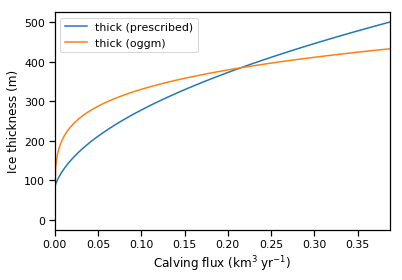

In [11]:
df[['flux', 'thick (prescribed)', 'thick (oggm)']].plot(x='flux');
plt.xlabel('Calving flux (km$^3$ yr$^{-1}$)');
plt.ylabel('Ice thickness (m)');

We already know that the calving law relates the thickness to the flux with a root of degree two (blue curve). Now, what explains the shape of **the orange curve**?. It is Glen's flow law, which relates ice thickness to the flux with a 5th degree root (assuming n=3). This is the reason why there is one (and only one) non-zero solution to the problem of finding a calving flux which is compatible with both the calving law and the physics of ice deformation (under our simplified framework of course).

Note that adding sliding doesn't change the problem (we still solve a polynome of degree 5 in OGGM, [with a new term in degree 3](https://docs.oggm.org/en/latest/ice-dynamics.html)):

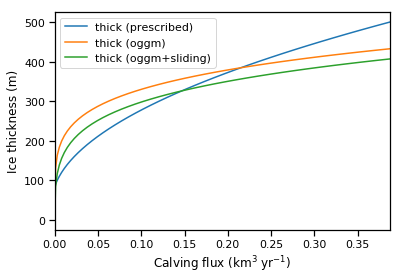

In [12]:
df[['flux', 'thick (prescribed)', 'thick (oggm)', 'thick (oggm+sliding)']].plot(x='flux');
plt.xlabel('Calving flux (km$^3$ yr$^{-1}$)');
plt.ylabel('Ice thickness (m)');   

**Mathematically speaking, this is not exactly true.**
We have two minimas in our thickness function: a small one and a large one (in the figure we can only see the large solution).
Now solve for the ice thickness equation via a [Bound-Constrained minimization method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).


# Optimum thickness 

What we want its to solve for $h$ in the following equations: 

$$q_{calving} - q_{OGGM} = 0 \; (EQ. \: 2)$$

For the case of a rectangular bed and without accounting for sliding we have (See [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/) for the details on the equations): 
    
    
$$k h d w \; - \; \frac{2 A}{n + 2} h (\rho g \alpha h)^n h w = 0 \; (EQ. \: 3)$$ 
        
Now lets replace $h$ with $h$ = $d$ + $E_{t}$     

$$ k (d + E_{t}) d w - \frac{2 A}{n + 2} (d + E_{t}) (\rho g \alpha (d + E_{t}))^n (d + E_{t}) w = 0 \; (EQ. \: 4)$$

$k$: calving constant of proporcionality   
$E_{t}$ : Free board     
$w$: width     
$A$: Glen's flow law creep parameter    
$n$: 3.    
$\rho$ : ice density  
$g$: gravity     
$\alpha$: slope angle

We do this by first finding the absolute minimum of **EQ. 3**, and numerically solving for $d$ (In the case of sliding there is an extra term at the right hand side of the equation).

In [13]:
from scipy import optimize
from oggm.core.inversion import sia_thickness

We get the variables needed to solve **EQ.3** and define our objective functions (without sliding and with sliding):

In [14]:
cls = gdir.read_pickle('inversion_input')[-1]
slope = cls['slope_angle'][-1]
width = cls['width'][-1]

def to_minimize(wd):
    fl = calving_flux_from_depth(gdir, water_depth=wd)
    oggm = sia_thickness([slope], [width], np.array([fl['flux'] * 1e9 / cfg.SEC_IN_YEAR]))[0]
    return fl['thick'] - oggm


def to_minimize_with_sliding(wd):
    fl = calving_flux_from_depth(gdir, water_depth=wd)
    oggm = sia_thickness([slope], [width], np.array([fl['flux'] * 1e9 / cfg.SEC_IN_YEAR]),
                         fs=5.7e-20)[0]
    return fl['thick'] - oggm

### Comment to Fabien
1. Why we dont say that we solve for a **water depth** instead of **h**. I find very confusing since in the code we always minimise for the water depth. I think we will be more transparent, if we clearly state the variable that we solved. Let me know if I am right here? This is the only thing I dont fully get, from the code, the variable to minimise should be consistent with text explanation

In [15]:
wd = np.linspace(0.1, 400)

out = []
for w in wd:
    out.append(to_minimize(w))

out_fs = []
for w in wd:
    out_fs.append(to_minimize_with_sliding(w))

dg = pd.DataFrame(list(zip(wd, out, out_fs)),
                  columns=['Water depth [m]',
                           'Calving law - OGGM',
                           'Calving law - OGGM (with sliding)'])

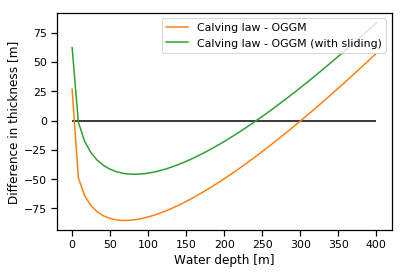

In [16]:
plt.plot(dg['Water depth [m]'], dg['Calving law - OGGM'], 'C1');
plt.plot(dg['Water depth [m]'], dg['Calving law - OGGM (with sliding)'], 'C2');
plt.hlines([0], 0, 400);
plt.xlabel('Water depth [m]');
plt.ylabel('Difference in thickness [m]');
plt.legend(loc='upper right');

First the code finds the absolute minimum of **EQ. 3** using the python tool: [optimize.minimize()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). 

In [17]:
abs_min = optimize.minimize(to_minimize, [1], bounds=((1e-4, 1e4), ))
abs_min['x'][0]

69.28590699561889

Now we find the roots of **EQ.3** between the interval [0.0001 - 10000]. Using the python tool: [optimize.brentq()](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.brentq.html)

But we have two minima:

In [18]:
print('Optimum small (in m)', optimize.brentq(to_minimize, 1e-4, abs_min['x'][0]))
print('Optimum large (in m)', optimize.brentq(to_minimize, abs_min['x'][0], 1e4))

opt = optimize.brentq(to_minimize, abs_min['x'][0], 1e4)

Optimum small (in m) 0.7080626350455591
Optimum large (in m) 300.5907750402363


Now we give this value to the calving law and calculate a flux:

In [19]:
out = calving_flux_from_depth(gdir, water_depth=opt)
out

{'flux': 0.2150464424077896,
 'width': 775.0304918212076,
 'thick': 384.6153236274726,
 'water_depth': 300.5907750402363,
 'free_board': 84.02454858723632}

In [20]:
out = find_inversion_calving(gdir)
out

{'calving_flux': 0.21504644240778903,
 'calving_mu_star': 78.28372100138874,
 'calving_law_flux': 0.21504644240778925,
 'calving_slope': 0.11652596877875702,
 'calving_thick': 384.6153236274723,
 'calving_water_depth': 300.590775040236,
 'calving_free_board': 84.02454858723632}

## Testing consistency (the reviewer asked for this test)

In [22]:
thick = out['calving_thick'] 
df = calving_flux_from_depth(gdir, thick=thick)
df

{'flux': 0.21504644240778925,
 'width': 775.0304918212076,
 'thick': 384.6153236274723,
 'water_depth': 300.590775040236,
 'free_board': 84.02454858723632}

Same flux!!

## But what about mass conservation and the temperature sensitivity $\mu$ * ? 

We still need to check with the mass balace module if the flux computed above complies with mass conservation; the frontal ablation flux cannot exceed the mass accumulated on the glacier via Precipitation.

We try a big number for the $k$ parameter. 

In [23]:
cfg.PARAMS['k_calving'] = 2.4*10
out = find_inversion_calving(gdir)
out

2019-06-26 18:09:44: oggm.core.climate: MassBalanceCalibrationError occurred during task local_t_star on RGI60-01.03622: mu* out of specified bounds: -652.32


{'calving_flux': 1.5536260003092384,
 'calving_mu_star': 0.0,
 'calving_law_flux': 5.176143332328355,
 'calving_slope': 0.11652596877875702,
 'calving_thick': 571.2016152101778,
 'calving_water_depth': 487.1770666229415,
 'calving_free_board': 84.02454858723632}

## Question to Fabien
2. How does the clipping of the $\mu$ * happens? You say that you take values down to zero before stopping but what exactly do you iterate? If the flux calculated exceeds the precipitation. How do you find the flux that has a value smaller than that? 

### Now we try some other random glaciers 

In [24]:
cfg.PARAMS['k_calving'] = 2.4

ids = [
'RGI60-01.04375',
'RGI60-01.03377',
'RGI60-01.01390',
'RGI60-01.14391',
'RGI60-01.20891',
'RGI60-01.10612',
'RGI60-01.17807'
]

for rid in ids:

    gdir = workflow.init_glacier_regions([rid], from_prepro_level=3)[0]

    cls = gdir.read_pickle('inversion_input')[-1]
    slope = cls['slope_angle'][-1]
    width = cls['width'][-1]

    def to_minimize(wd):
        fl = calving_flux_from_depth(gdir, water_depth=wd)
        oggm = sia_thickness([slope], [width], np.array([fl['flux'] * 1e9 / cfg.SEC_IN_YEAR]))[0]
        return fl['thick'] - oggm
    
    abs_min = optimize.minimize(to_minimize, [1], bounds=((1e-4, 1e4), ))
    print(rid)
    print('Optimum small (in m)', optimize.brentq(to_minimize, 1e-4, abs_min['x'][0]))
    print('Optimum large (in m)', optimize.brentq(to_minimize, abs_min['x'][0], 1e4))
    print('')

2019-06-26 18:09:53: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-06-26 18:09:53: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2019-06-26 18:09:53: oggm.workflow: Multiprocessing: using all available processors (N=4)


RGI60-01.04375
Optimum small (in m) 4.121563953290968


2019-06-26 18:10:00: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-06-26 18:10:00: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


Optimum large (in m) 752.7437352984979

RGI60-01.03377


2019-06-26 18:10:06: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-06-26 18:10:06: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


Optimum small (in m) 1.7732504831037135
Optimum large (in m) 496.56993181736465



2019-06-26 18:10:12: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-06-26 18:10:12: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


RGI60-01.01390
Optimum small (in m) 0.09681963817572017
Optimum large (in m) 508.16734196725366



2019-06-26 18:10:19: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-06-26 18:10:19: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


RGI60-01.14391
Optimum small (in m) 0.08804286419001388
Optimum large (in m) 1120.424364160108



2019-06-26 18:10:20: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-06-26 18:10:20: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


RGI60-01.20891
Optimum small (in m) 0.09036018145176102
Optimum large (in m) 681.2980722094586



2019-06-26 18:10:20: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-06-26 18:10:20: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


RGI60-01.10612
Optimum small (in m) 40.46799721361095
Optimum large (in m) 372.47568428662237

RGI60-01.17807
Optimum small (in m) 11.73571818590173
Optimum large (in m) 167.17849992660035



**The solution implemented in OGGM always seeks for the larger one**

## What about glaciers where no optimal thickness exists?

We know one example: RGI60-01.23642, Tsaa Glacier. This glacier never has an optimum h. 

2019-06-26 18:10:30: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-06-26 18:10:31: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


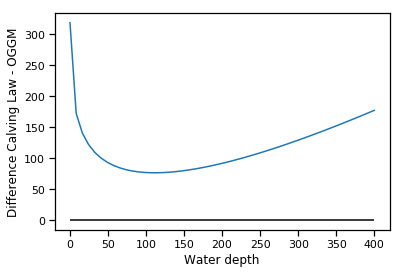

In [25]:
gdir = workflow.init_glacier_regions(['RGI60-01.23642'], from_prepro_level=3)[0]

cls = gdir.read_pickle('inversion_input')[-1]
slope = cls['slope_angle'][-1]
width = cls['width'][-1]

def to_minimize(wd):
    fl = calving_flux_from_depth(gdir, water_depth=wd)
    oggm = sia_thickness([slope], [width], np.array([fl['flux'] * 1e9 / cfg.SEC_IN_YEAR]))[0]
    return fl['thick'] - oggm

wd = np.linspace(0.1, 400)
out = []
for w in wd:
    out.append(to_minimize(w)) 
    
plt.plot(wd, out);
plt.hlines([0], 0, 400);
plt.xlabel('Water depth');
plt.ylabel('Difference Calving Law - OGGM');

These galciers (6 glaciers in Alaska) have a calving flux of zero in the current code. By guessing a water depth we can see the terminus variables:

In [26]:
calving_flux_from_depth(gdir, water_depth=100)

{'flux': 0.6326069410087505,
 'width': 5001.6722770291335,
 'thick': 526.9961941146537,
 'water_depth': 100,
 'free_board': 426.9961941146537}

### The following section is just for me to understand the non calving problem. I think that simply for these glaciers equilibrium does not apply with the current terminus geometry.

In [27]:
abs_min = optimize.minimize(to_minimize, [1], bounds=((-1e4, 1e4), ))

In [28]:
abs_min

      fun: array([76.80501614])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.13686838e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 22
      nit: 9
   status: 0
  success: True
        x: array([111.43111313])

In [29]:
df = []
for thick in np.linspace(0, 530, 51):
    # This function simply computes the calving law
    out = calving_flux_from_depth(gdir, thick=thick)
    out['thick (prescribed)'] = out.pop('thick')
    
    # Now we feed it back to OGGM
    gdir.inversion_calving_rate = out['flux']
    
    # The mass-balance has to adapt in order to create a flux
    tasks.local_t_star(gdir)    
    tasks.mu_star_calibration(gdir)
    tasks.prepare_for_inversion(gdir)
    v_inv, _ = tasks.mass_conservation_inversion(gdir)
    
    # Now we get the OGGM ice thickness 
    out['thick (oggm)'] = calving_flux_from_depth(gdir)['thick']
    
    # Add sliding (the fs value is outdated, but still)
    v_inv, _ = tasks.mass_conservation_inversion(gdir, fs=5.7e-20)
    out['thick (oggm+sliding)'] = calving_flux_from_depth(gdir)['thick']
    
    # Store
    df.append(out)
    
df = pd.DataFrame(df)

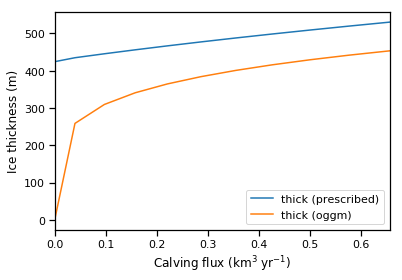

In [30]:
df[['flux', 'thick (prescribed)', 'thick (oggm)']].plot(x='flux');
plt.xlabel('Calving flux (km$^3$ yr$^{-1}$)');
plt.ylabel('Ice thickness (m)');

## some silly thoughts from me

I think both curves will never meet in a domain between $q_{calving}$ $>$ 0 and a $q_{calving}$ that results in a non negative $\mu$*. 

The difference between both fluxes in **EQ. 3** is corresponds to a glacier state outside of equilibrium under that geometry. 
Maybe we just didn't guess the t* correctly for this glacier. There is very little precipitation, or the whole terminus geometry is wrong. 
